<a href="https://colab.research.google.com/github/wasuratme96/Deep-Reinforcement-Learning/blob/main/Deep%20RL%20Class/unit5/Policy_Gradient_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 5: Code your first Deep Reinforcement Learning Algorithm with PyTorch: Reinforce. And test its robustness 💪
In this notebook, you'll code your first Deep Reinforcement Learning algorithm from scratch: Reinforce (also called Monte Carlo Policy Gradient).

Reinforce is a *Policy-Based Method*: a Deep Reinforcement Learning algorithm that tries **to optimize the policy directly without using an action-value function**.
More precisely, Reinforce is a *Policy-Gradient Method*, a subclass of *Policy-Based Methods* that aims **to optimize the policy directly by estimating the weights of the optimal policy using Gradient Ascent**.

To test its robustness, we're going to train it in 3 different simple environments:
- Cartpole-v1
- PongEnv
- PixelcopterEnv

❓ If you have questions, please post them on #study-group-unit1 discord channel 👉 https://discord.gg/aYka4Yhff9

🎮 Environments: 
- [CartPole-v1](https://www.gymlibrary.ml/environments/classic_control/cart_pole/)
- [PixelCopter](https://pygame-learning-environment.readthedocs.io/en/latest/user/games/pixelcopter.html)
- [Pong](https://pygame-learning-environment.readthedocs.io/en/latest/user/games/pong.html)

⬇️ Here is an example of what **you will achieve in just a few minutes.** ⬇️

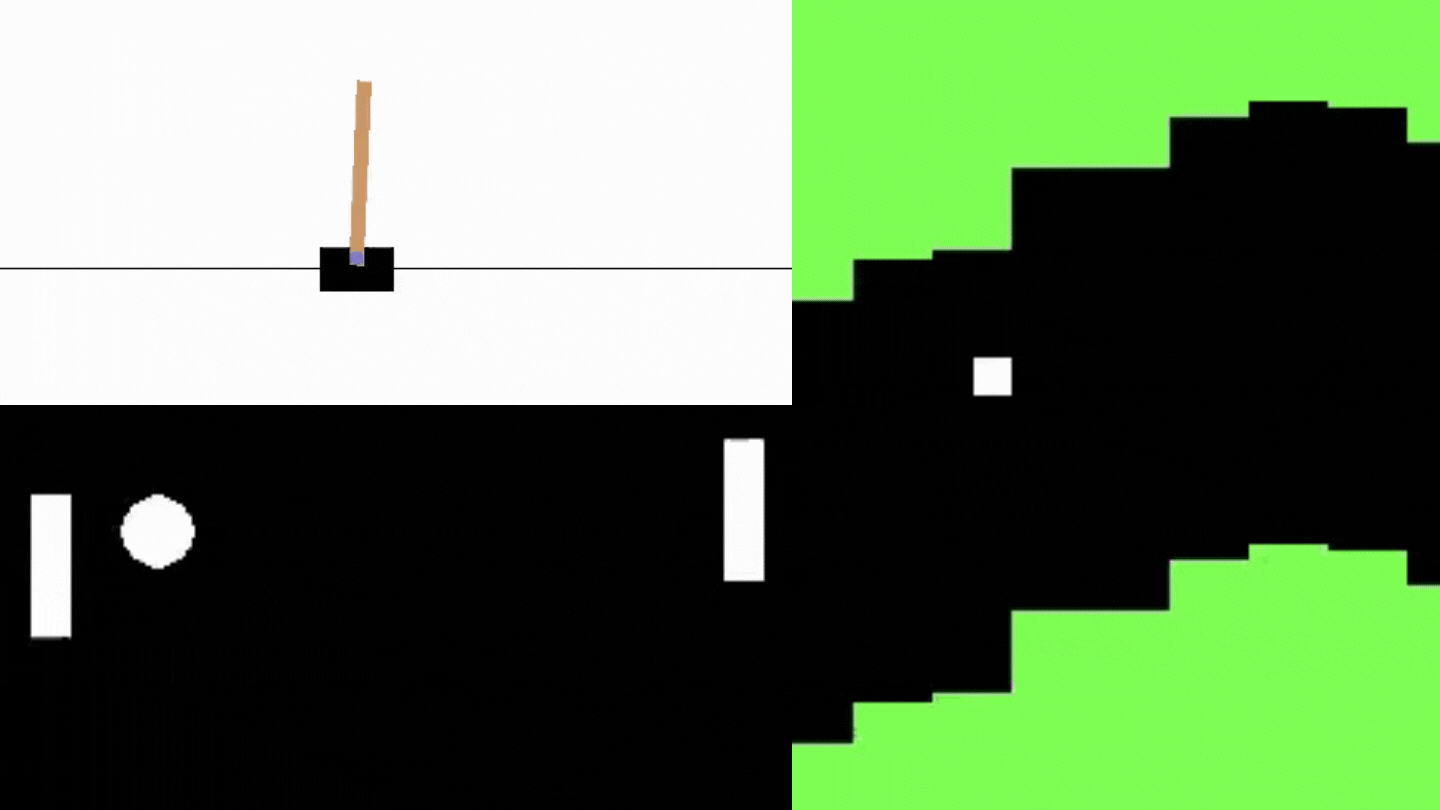

## Objectives of this notebook 🏆
At the end of the notebook, you will:
- Be able to **code from scratch a Reinforce algorithm using PyTorch.**
- Be able to **test the robustness of your agent using simple environments.**
- Be able to **push your trained agent to the Hub** with a nice video replay and an evaluation score 🔥.

## Prerequisites 🏗️
Before diving into the notebook, you need to:

🔲 📚 [Read the Unit 4 Readme](https://github.com/huggingface/deep-rl-class/blob/main/unit4/README.md) contains all the information.

🔲 📚 **Study Policy Gradients** by reading the chapter 👉 https://huggingface.co/blog/deep-rl-pg 

- `Hardware Accelerator > GPU`


During the notebook, we'll need to generate a replay video. To do so, with colab, **we need to have a virtual screen to be able to render the environment** (and thus record the frames). 

Hence the following cell will install virtual screen libraries and create and run a virtual screen 🖥

In [ ]:
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(500, 500))
virtual_display.start()

### Step 1: Install dependencies 🔽
The first step is to install the dependencies, we’ll install multiple ones:

- `gym`
- `gym-games`: Extra gym environments made with PyGame.
- `huggingface_hub`: 🤗 works as a central place where anyone can share and explore models and datasets. It has versioning, metrics, visualizations and other features that will allow you to easily collaborate with others.

You can see here all the Reinforce models available 👉 https://huggingface.co/models?other=reinforce

And you can find all the Deep Reinforcement Learning models here 👉 https://huggingface.co/models?pipeline_tag=reinforcement-learning


In [ ]:
!pip install gym
!pip install git+https://github.com/ntasfi/PyGame-Learning-Environment.git
!pip install git+https://github.com/qlan3/gym-games.git
!pip install huggingface_hub

!pip install pyyaml==6.0 # avoid key error metadata

!pip install pyglet # Virtual Screen
!pip install imageio-ffmpeg

### Step 2: Import the packages 📦
In addition to the installed libraries, we also use:

- `imageio`: To generate a replay video



In [ ]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
import gym_pygame

from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.

import imageio

- Let's check if we have a GPU
- If it's the case you should see `device:cuda0`

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

We're now ready to implement our Reinforce algorithm 🔥

## First agent: Playing CartPole-v1 🤖

### Step 3: Create the CartPole environment and understand how it works
#### [The environment 🎮](https://www.gymlibrary.ml/environments/classic_control/cart_pole/)


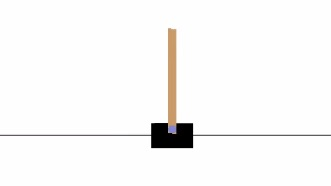

### Why do we use a simple environment like CartPole-v1?
As explained in [Reinforcement Learning Tips and Tricks](https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html), when you implement your agent from scratch you need **to be sure that it works correctly and find bugs with easy environments before going deeper**. Since finding bugs will be much easier in simple environments.


> Try to have some “sign of life” on toy problems


> Validate the implementation by making it run on harder and harder envs (you can compare results against the RL zoo). You usually need to run hyperparameter optimization for that step.
___
#### The CartPole-v1 environment

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.



So, we start with CartPole-v1. The goal is to push the cart left or right **so that the pole stays in the equilibrium.**

The episode ends if:
- The pole Angle is greater than ±12°
- Cart Position is greater than ±2.4
- Episode length is greater than 500

We get a reward 💰 of +1 every timestep the Pole stays in the equilibrium.

In [ ]:
env_id = "CartPole-v1"
# Create the env
env = gym.make(env_id)

# Create the evaluation env
eval_env = gym.make(env_id)

# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

In [ ]:
s_size, a_size

In [ ]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action

### Step 4: Let's build the Reinforce Architecture
This implementation is based on two implementations:
- [PyTorch official Reinforcement Learning example](https://github.com/pytorch/examples/blob/main/reinforcement_learning/reinforce.py)
- [Udacity Reinforce](https://github.com/udacity/deep-reinforcement-learning/blob/master/reinforce/REINFORCE.ipynb)

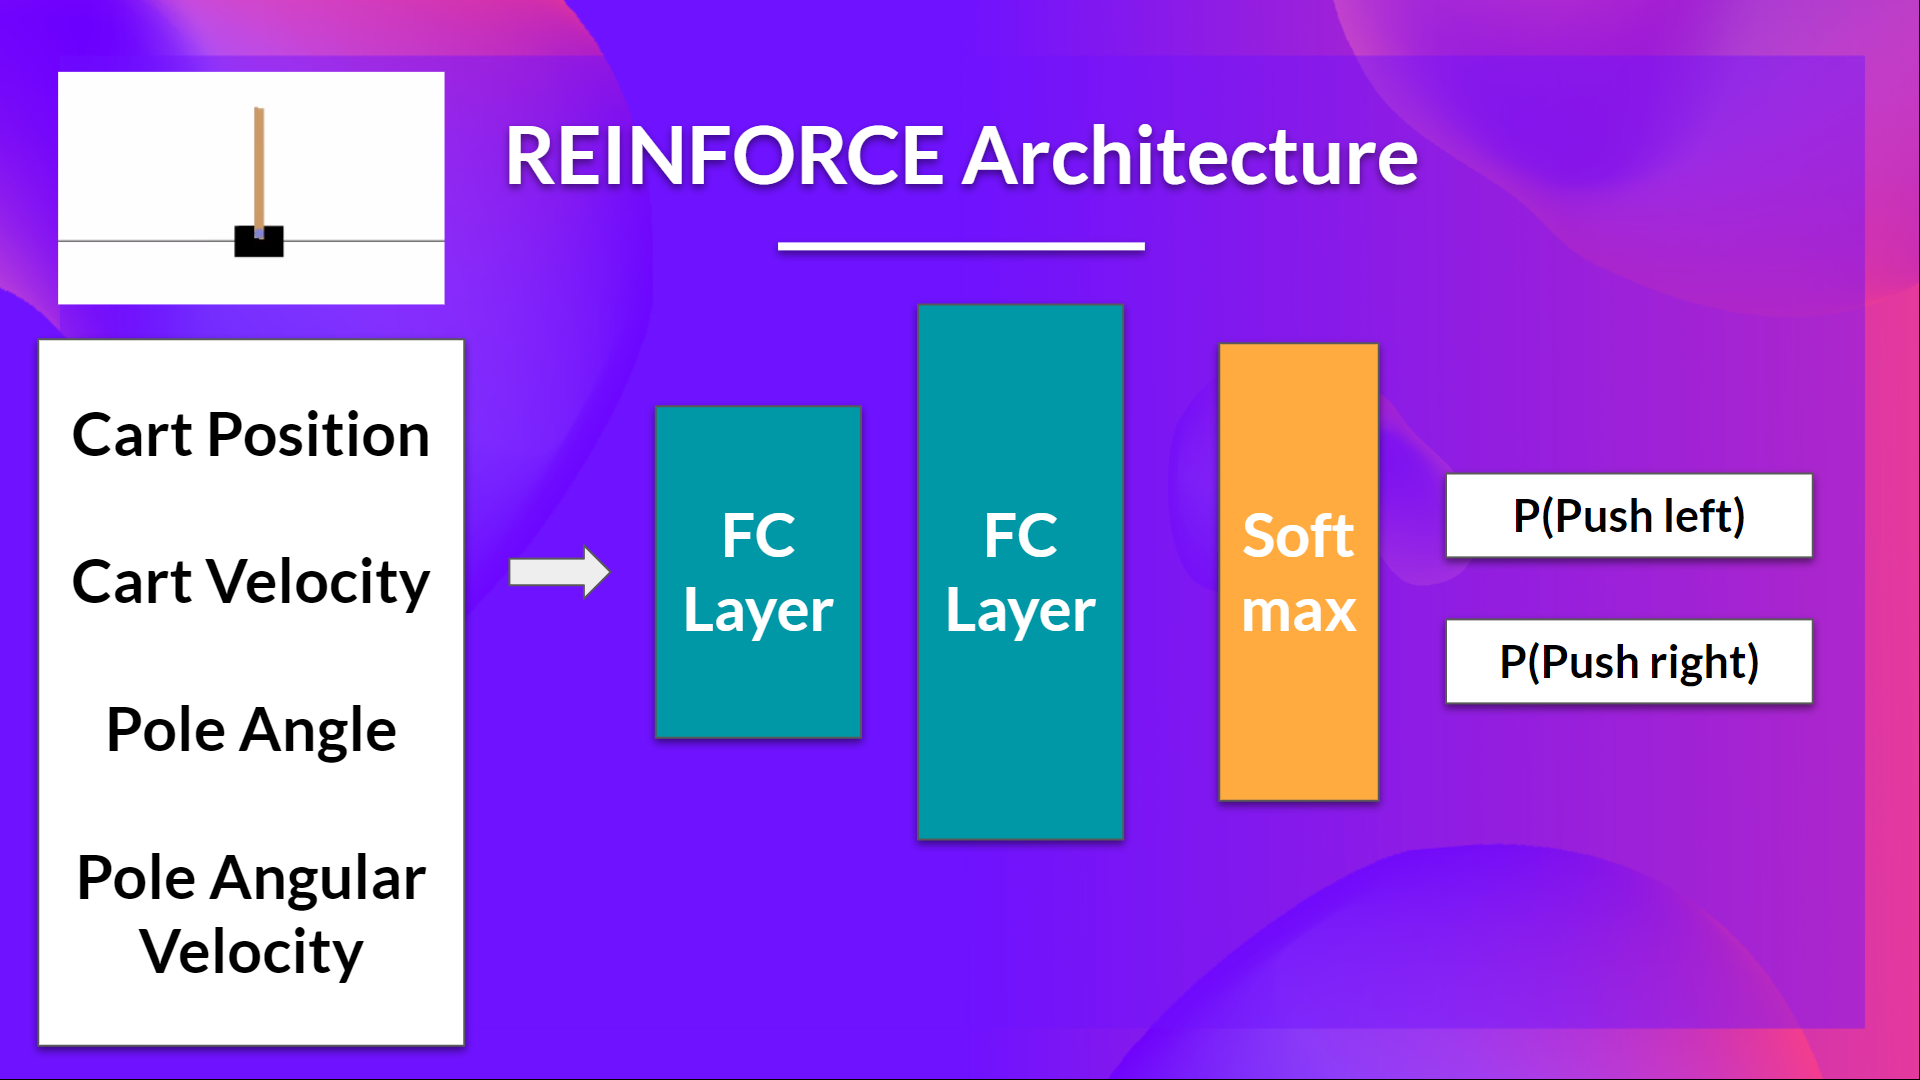

So we want:
- Two fully connected layers (fc1 and fc2).
- Using ReLU as activation function of fc1
- Using Softmax to output a probability distribution over actions
- Since **we want to sample an action from the probability distribution over actions**, we can't use `action = np.argmax(m)` since it will always output the action that have the highest probability.

- We need to replace with `action = m.sample()` that will sample an action from the probability distribution P(.|s)

In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) # Store the tensors of state to target device
        probs = self.forward(state).cpu() # Return tensors of probability to CPU memory

        # Turn probability of action in tensor to a categorical distribution
        m = Categorical(probs)
        action = m.sample()   # Sample action from categorical distribution base on probability of each action
        return action.item(), m.log_prob(action)

By using CartPole, it was easier to debug since **we know that the bug comes from our integration and not from our simple environment**.

### Step 5: Build the Reinforce Training Algorithm
- Contrary to the pseudocode, we update our policy after every episode and **not using a batch of episodes**.



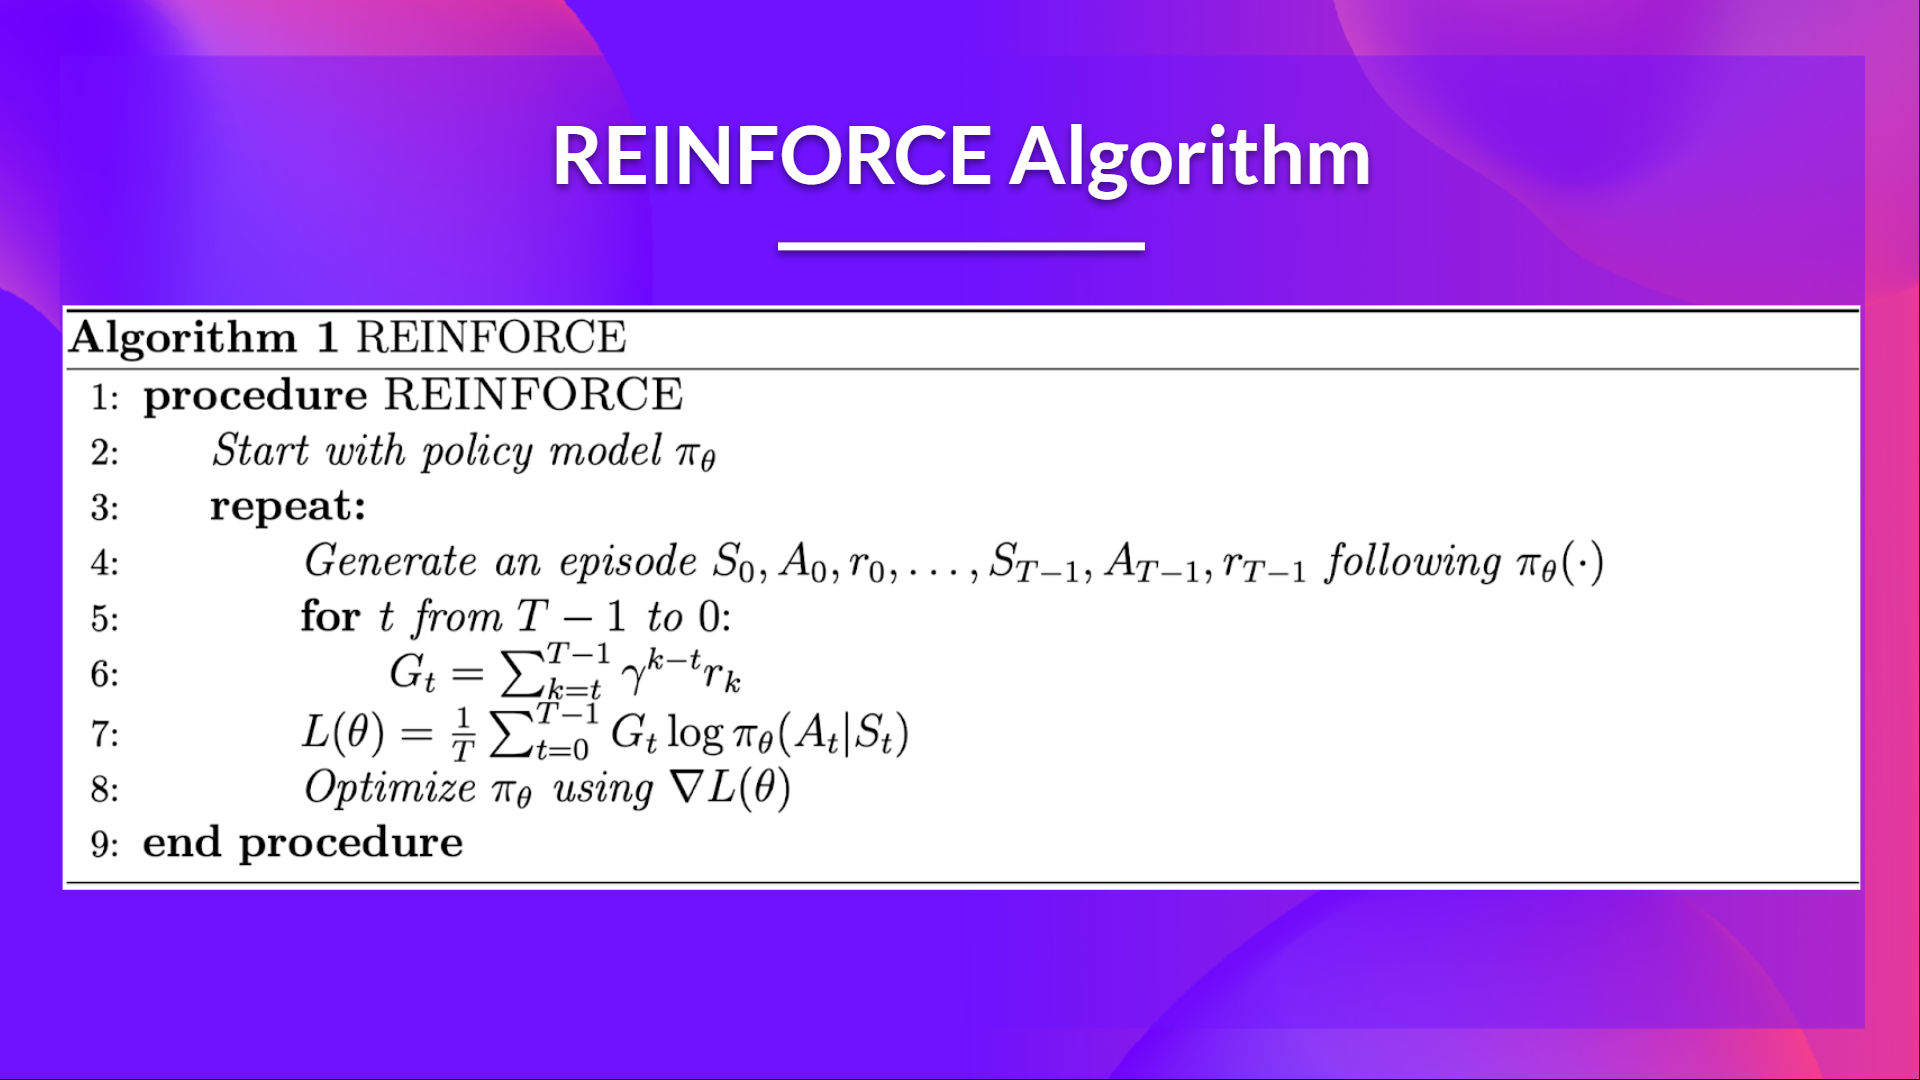

Why do we minimize the loss? You talked about Gradient Ascent not Gradient Descent?

- We want to maximize our utility function $J(\theta)$ but in PyTorch like in Tensorflow it's better to **minimize an objective function.**
    - So let's say we want to reinforce action 3 at a certain timestep. Before training this action P is 0.25.
    - So we want to modify $\theta$ such that $\pi_\theta(a_3|s; \theta) > 0.25$
    - Because all P must sum to 1, max $\pi_\theta(a_3|s; \theta)$ will **minimize other action probability.**
    - So we should tell PyTorch **to min $1 - \pi_\theta(a_3|s; \theta)$.**
    - This loss function approaches 0 as $\pi_\theta(a_3|s; \theta)$ nears 1.
    - So we are encouraging the gradient to max $\pi_\theta(a_3|s; \theta)$

In [ ]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    # Line 3 of pseudocode
    # 1 loop = 1 episode
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset() # reset the environment to random initial status 
        # Line 4 of pseudocode
        # max_t is maximum step per episode
        for t in range(max_t):
            action, log_prob = policy.act(state) # get the action and log probability of that action(tensor)
            saved_log_probs.append(log_prob)  # Collect probability of action
            state, reward, done, _ = env.step(action) # take an env step
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        # Line 6 of pseudocode: calculate the return
        ## Here, we calculate discounts for instance [0.99^1, 0.99^2, 0.99^3, ..., 0.99^len(rewards)]
        discounts = [gamma**i for i in range(len(rewards)+1)]
        ## We calculate the return by sum(gamma[t] * reward[t]) 
        R = sum([a*b for a,b in zip(discounts, scores)]) # what do we need to put in zip() remember that we calculate gamma[t] * reward[t]
        
        # Line 7:
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        # Line 8: PyTorch prefers 
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
    return scores

### Train it
- We're now ready to train our agent.
- But first, we define a variable containing all the training hyperparameters.

In [ ]:
cartpole_hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0, # No discount
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [ ]:
# Create policy and place it to the device
cartpole_policy = Policy(cartpole_hyperparameters["state_space"], 
                         cartpole_hyperparameters["action_space"], 
                         cartpole_hyperparameters["h_size"]).to(device)

# Place learnable parameter to be Policy parameters
cartpole_optimizer = optim.Adam(cartpole_policy.parameters(), 
                                lr=cartpole_hyperparameters["lr"])

In [ ]:
scores = reinforce(cartpole_policy,
                   cartpole_optimizer,
                   cartpole_hyperparameters["n_training_episodes"], 
                   cartpole_hyperparameters["max_t"],
                   cartpole_hyperparameters["gamma"], 
                   100)

### Step 6: Define evaluation method 📝

In [ ]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
    
    for step in range(max_steps):
      action, _ = policy.act(state)
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward
        
      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

### Step 7: Evaluate our agent 📈

In [ ]:
evaluate_agent(eval_env, 
               cartpole_hyperparameters["max_t"], 
               cartpole_hyperparameters["n_evaluation_episodes"],
               cartpole_policy)

### Step 8: Publish our trained model on the Hub 🔥
Now that we saw we got good results after the training, we can publish our trained model on the hub 🤗 with one line of code.

Under the hood, the Hub uses git-based repositories (don't worry if you don't know what git is), which means you can update the model with new versions as you experiment and improve your agent.

### Push to the Hub
#### Do not modify this code

In [ ]:
%%capture
from huggingface_hub import HfApi, HfFolder, Repository
from huggingface_hub.repocard import metadata_eval_result, metadata_save

from pathlib import Path
import datetime
import json

import imageio

In [ ]:
def record_video(env, policy, out_directory, fps=30):
  images = []  
  done = False
  state = env.reset()
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action, _ = policy.act(state)
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [ ]:
import os
def package_to_hub(repo_id, 
                model,
                hyperparameters,
                eval_env,
                video_fps=30,
                local_repo_path="hub",
                commit_message="Push Reinforce agent to the Hub",
                token= None
                ):
  _, repo_name = repo_id.split("/")
  
  # Step 1: Clone or create the repo
  # Create the repo (or clone its content if it's nonempty)
  api = HfApi()
  
  repo_url = api.create_repo(
        repo_id=repo_id,
        token=token,
        private=False,
        exist_ok=True,)
  
  # Git pull
  repo_local_path = Path(local_repo_path) / repo_name
  repo = Repository(repo_local_path, clone_from=repo_url, use_auth_token=True)
  repo.git_pull()
  
  repo.lfs_track(["*.mp4"])

  # Step 1: Save the model
  torch.save(model, os.path.join(repo_local_path,"model.pt"))

  # Step 2: Save the hyperparameters to JSON
  with open(Path(repo_local_path) / "hyperparameters.json", "w") as outfile:
    json.dump(hyperparameters, outfile)
  
  # Step 2: Evaluate the model and build JSON
  mean_reward, std_reward = evaluate_agent(eval_env, 
                                           hyperparameters["max_t"],
                                           hyperparameters["n_evaluation_episodes"], 
                                           model)

  # First get datetime
  eval_datetime = datetime.datetime.now()
  eval_form_datetime = eval_datetime.isoformat()

  evaluate_data = {
        "env_id": hyperparameters["env_id"], 
        "mean_reward": mean_reward,
        "n_evaluation_episodes": hyperparameters["n_evaluation_episodes"],
        "eval_datetime": eval_form_datetime,
  }
  # Write a JSON file
  with open(Path(repo_local_path) / "results.json", "w") as outfile:
      json.dump(evaluate_data, outfile)

  # Step 3: Create the model card
  # Env id
  env_name = hyperparameters["env_id"]
  
  metadata = {}
  metadata["tags"] = [
        env_name,
        "reinforce",
        "reinforcement-learning",
        "custom-implementation",
        "deep-rl-class"
    ]

  # Add metrics
  eval = metadata_eval_result(
      model_pretty_name=repo_name,
      task_pretty_name="reinforcement-learning",
      task_id="reinforcement-learning",
      metrics_pretty_name="mean_reward",
      metrics_id="mean_reward",
      metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
      dataset_pretty_name=env_name,
      dataset_id=env_name,
    )

  # Merges both dictionaries
  metadata = {**metadata, **eval}

  model_card = f"""
  # **Reinforce** Agent playing **{env_id}**
  This is a trained model of a **Reinforce** agent playing **{env_id}** .
  To learn to use this model and train yours check Unit 5 of the Deep Reinforcement Learning Class: https://github.com/huggingface/deep-rl-class/tree/main/unit5
  """

  readme_path = repo_local_path / "README.md"
  readme = ""
  if readme_path.exists():
      with readme_path.open("r", encoding="utf8") as f:
        readme = f.read()
  else:
    readme = model_card

  with readme_path.open("w", encoding="utf-8") as f:
    f.write(readme)

  # Save our metrics to Readme metadata
  metadata_save(readme_path, metadata)

  # Step 4: Record a video
  video_path =  repo_local_path / "replay.mp4"
  record_video(env, model, video_path, video_fps)
  
  # Push everything to hub
  print(f"Pushing repo {repo_name} to the Hugging Face Hub")
  repo.push_to_hub(commit_message=commit_message)

  print(f"Your model is pushed to the hub. You can view your model here: {repo_url}")

### .
By using `package_to_hub` **you evaluate, record a replay, generate a model card of your agent and push it to the hub**.

This way:
- You can **showcase our work** 🔥
- You can **visualize your agent playing** 👀
- You can **share with the community an agent that others can use** 💾
- You can **access a leaderboard 🏆 to see how well your agent is performing compared to your classmates** 👉 https://huggingface.co/spaces/chrisjay/Deep-Reinforcement-Learning-Leaderboard

To be able to share your model with the community there are three more steps to follow:

1️⃣ (If it's not already done) create an account to HF ➡ https://huggingface.co/join

2️⃣ Sign in and then, you need to store your authentication token from the Hugging Face website.
- Create a new token (https://huggingface.co/settings/tokens) **with write role**

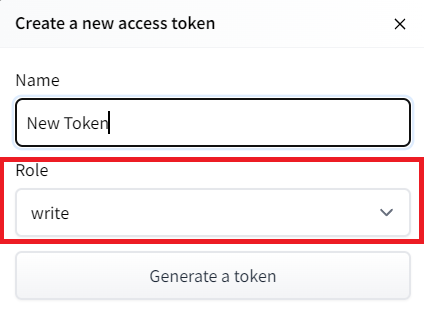

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!git config --global credential.helper store

If you don't want to use a Google Colab or a Jupyter Notebook, you need to use this command instead: `huggingface-cli login`

3️⃣ We're now ready to push our trained agent to the 🤗 Hub 🔥 using `package_to_hub()` function

In [ ]:
repo_id = "WasuratS/Reinforce-cartpole" #TODO Define your repo id {username/Reinforce-{model-id}}
package_to_hub(repo_id,
                cartpole_policy, # The model we want to save
                cartpole_hyperparameters, # Hyperparameters
                eval_env, # Evaluation environment
                video_fps=30,
                local_repo_path="hub",
                commit_message="Push Reinforce agent to the Hub",
                )

Now that we try the robustness of our implementation, let's try with more complex environments such as:
- Pixelcopter
- Pong




## Second agent: PixelCopter 🚁

### Step 1: Study the PixelCopter environment 👀
- [The Environment documentation](https://pygame-learning-environment.readthedocs.io/en/latest/user/games/pixelcopter.html)

The observation space (7) 👀:
- player y position
- player velocity
- player distance to floor
- player distance to ceiling
- next block x distance to player
- next blocks top y location
- next blocks bottom y location

The action space(2) 🎮:
- Up
- Down

The reward function 💰: 
- For each vertical block it passes through it gains a positive reward of +1. Each time a terminal state reached it receives a negative reward of -1.

In [ ]:
env_id = "Pixelcopter-PLE-v0"
env = gym.make(env_id)
eval_env = gym.make(env_id)
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

### Step 2: Define the hyperparameters ⚙️
- Because this environment is more complex, we need to change the hyperparameters
- Especially the hidden size, we need more neurons.

In [ ]:
pixelcopter_hyperparameters = {
    "h_size": 128,
    "n_training_episodes": 80000,
    "n_evaluation_episodes": 20,
    "max_t": 10000,
    "gamma": 0.999,
    "lr": 1e-5,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [ ]:
# Create policy and place it to the device
# torch.manual_seed(50)
pixelcopter_policy = Policy(pixelcopter_hyperparameters["state_space"], 
                            pixelcopter_hyperparameters["action_space"], 
                            pixelcopter_hyperparameters["h_size"]).to(device)
                            
pixelcopter_optimizer = optim.Adam(pixelcopter_policy.parameters(), lr=pixelcopter_hyperparameters["lr"])

In [ ]:
scores = reinforce(pixelcopter_policy,
                   pixelcopter_optimizer,
                   pixelcopter_hyperparameters["n_training_episodes"], 
                   pixelcopter_hyperparameters["max_t"],
                   pixelcopter_hyperparameters["gamma"], 
                   1000)

In [ ]:
repo_id = f"WasuratS/Reinforce-{env_id}" #TODO Define your repo id {username/Reinforce-{model-id}}
package_to_hub(repo_id, 
                pixelcopter_policy,
                pixelcopter_hyperparameters,
                eval_env,
                video_fps=30,
                local_repo_path="hub",
                commit_message="Push Reinforce agent to the Hub",
                )

## Third agent: Pong 🎾

### Step 1: Study the Pong environment 👀
- [The Environment documentation](https://pygame-learning-environment.readthedocs.io/en/latest/user/games/pong.html)

The observation space (7) 👀:
- player y position
- players velocity
- cpu y position
- ball x position
- ball y position
- ball x velocity
- ball y velocity

The action space(3) 🎮:
- Paddle Up 
- Paddle Down 
- No movement

The reward function 💰: 
- The agent receives a positive reward, of +1, for each successful ball placed behind the opponents paddle, while it loses a point, -1, if the ball goes behind its paddle.

In [ ]:
env_id = "Pong-PLE-v0"
env = gym.make(env_id)
eval_env = gym.make(env_id)
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

### Step 2: Define the hyperparameters ⚙️ and improve the Policy
- Because this environment is more complex, we need to change the hyperparameters and create a deeper neural network.
- Especially the hidden size, we need more neurons.

In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h_size*2)
        self.fc3 = nn.Linear(h_size*2, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)


In [ ]:
pong_hyperparameters = {
    "h_size": 64,
    "n_training_episodes": 20000,
    "n_evaluation_episodes": 10,
    "max_t": 5000,
    "gamma": 0.99,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

### Step 3: Train the agent 🏃

In [ ]:
# Create policy and place it to the device
# torch.manual_seed(50)
pong_policy = Policy(pong_hyperparameters["state_space"], pong_hyperparameters["action_space"], pong_hyperparameters["h_size"]).to(device)
pong_optimizer = optim.Adam(pong_policy.parameters(), lr=pong_hyperparameters["lr"])

In [ ]:
scores = reinforce(pong_policy,
                   pong_optimizer,
                   pong_hyperparameters["n_training_episodes"], 
                   pong_hyperparameters["max_t"],
                   pong_hyperparameters["gamma"], 
                   1000)

### Step 4: Publish our trained model on the Hub 🔥

In [ ]:
repo_id = f"WasuratS/Reinforce-{env_id}" #TODO Define your repo id {username/Reinforce-{model-id}}
package_to_hub(repo_id,
                pong_policy, # The model we want to save
                pong_hyperparameters, # Hyperparameters
                eval_env, # Evaluation environment
                video_fps=30,
                local_repo_path="hub",
                commit_message="Push Reinforce agent to the Hub",
                )

### This is a course built with you 👷🏿‍♀️

We want to improve and update the course iteratively with your feedback. If you have some, please open an issue on the Github Repo: [https://github.com/huggingface/deep-rl-class/issues](https://github.com/huggingface/deep-rl-class/issues)

See you on Unit 6! 🔥
## Keep learning, stay awesome!